In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [103]:

with open("Data/processed_df.pkl", "rb") as f:
    df = pickle.load(f)

print(df.shape)

(404287, 6)


In [104]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Basic Feature Engineering
The following code block generates engineered features that capture textual similarity between the two questions in each pair:

q1_len, q2_len: Character lengths of Question 1 and Question 2.

q1_num_words, q2_num_words: Number of words in each question.

word_common: Count of common words between both questions.

word_total: Total number of unique words in both questions.

word_share: Ratio of shared words to total unique words (a normalized similarity score).

In [105]:
df['q1_len'] = df['question1'].str.len() 
df['q2_len'] = df['question2'].str.len()

In [106]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [107]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

df['word_common'] = df.apply(common_words, axis=1)

In [108]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

df['word_total'] = df.apply(total_words, axis=1)

In [109]:
df['word_share'] = round(df['word_common']/df['word_total'],2)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,23,0.43
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,20,0.20
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,24,0.17
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.00
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2,20,0.10


# Question Length Summary
  * Analyzed number of characters in each question.

    Helps understand text size before vectorization/modeling.

    Minimum length: very short questions.

    Maximum length: very detailed questions.

    Average length: moderate, suitable for ML/NLP processing

minimum characters 1
maximum characters 623
average num of characters 59


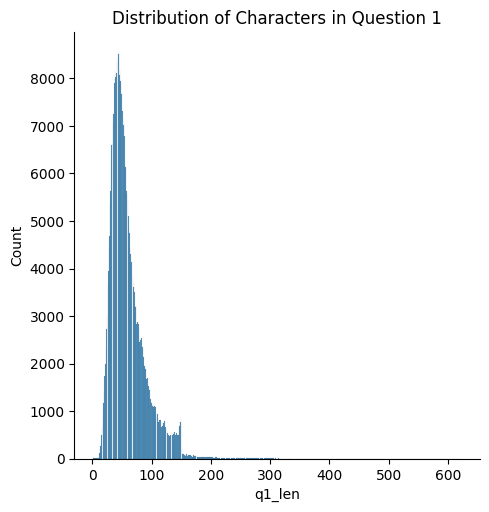

minimum characters 1
maximum characters 1169
average num of characters 60


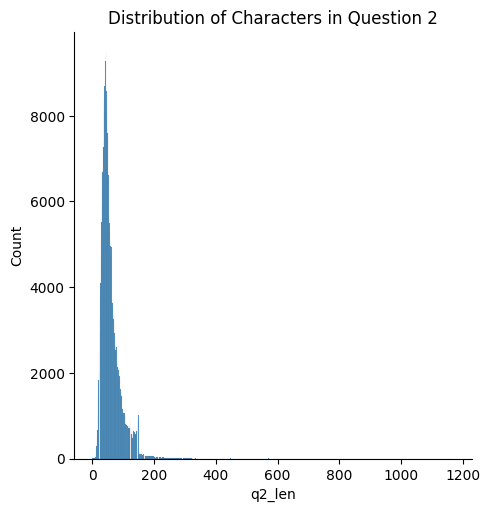

In [110]:
sns.displot(df['q1_len'])
plt.title('Distribution of Characters in Question 1')
print('minimum characters',df['q1_len'].min())
print('maximum characters',df['q1_len'].max())
print('average num of characters',int(df['q1_len'].mean()))
plt.show()

print("===================================================================")

sns.displot(df['q2_len'])
plt.title('Distribution of Characters in Question 2')
print('minimum characters',df['q2_len'].min())
print('maximum characters',df['q2_len'].max())
print('average num of characters',int(df['q2_len'].mean()))
plt.show()

* plots the distribution of the number of words in each question :

minimum words 1
maximum words 125
average num of words 10


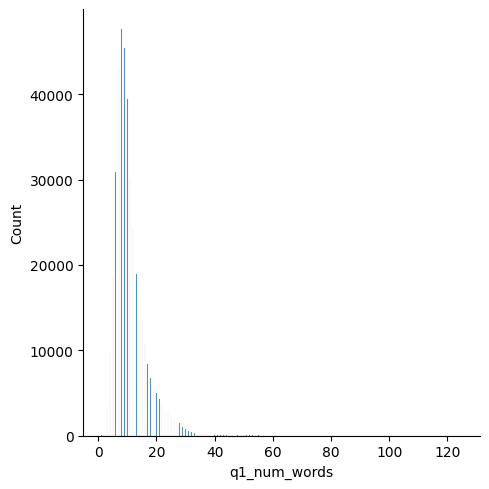

In [111]:
sns.displot(df['q1_num_words'])
print('minimum words',df['q1_num_words'].min())
print('maximum words',df['q1_num_words'].max())
print('average num of words',int(df['q1_num_words'].mean()))

minimum words 1
maximum words 237
average num of words 11


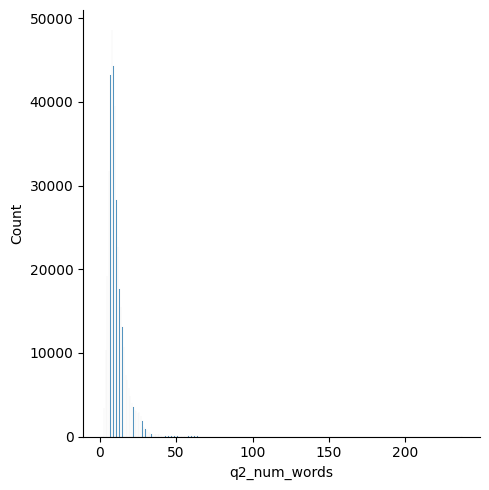

In [112]:
sns.displot(df['q2_num_words'])
print('minimum words',df['q2_num_words'].min())
print('maximum words',df['q2_num_words'].max())
print('average num of words',int(df['q2_num_words'].mean()))

# Distribution of Common Words Between Question Pairs
This plot shows the distribution of the number of common words between question pairs, separated by whether they are duplicates or not.

As the number of common words increases, the likelihood of the pair being a duplicate also increases.

A clear distinction can be observed:
Duplicate questions tend to share more words, while non-duplicates have fewer words in common.

This supports the idea that the word_common feature can be useful in predicting duplicates.

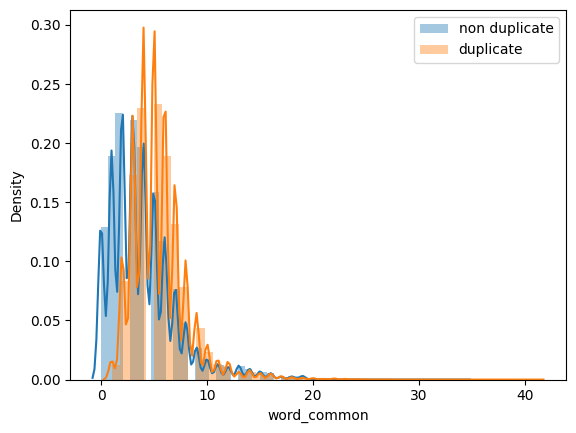

In [113]:
sns.distplot(df[df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()


# Distribution of Total Words in Question Pairs :
This plot compares the total number of unique words in question pairs for both duplicate and non-duplicate cases.

Non-duplicate pairs tend to have a slightly higher total word count, suggesting they are more different in wording.

Duplicate pairs generally have a lower total word count, implying they often share more similar phrasing or structure.

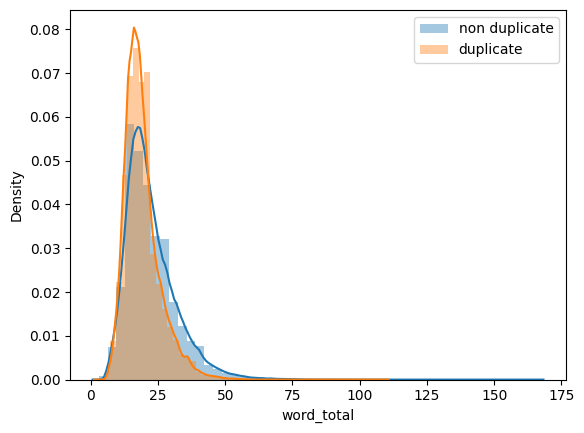

In [114]:
sns.distplot(df[df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

# Distribution of Word Share Between Question Pairs :
This plot shows the normalized word overlap between question pairs for both duplicate and non-duplicate cases.

Duplicate pairs have a higher word share, indicating they share a larger portion of common words.

Non-duplicate pairs typically have a lower word share, reflecting more distinct wording.

This confirms that word_share is a strong feature for identifying duplicate questions.

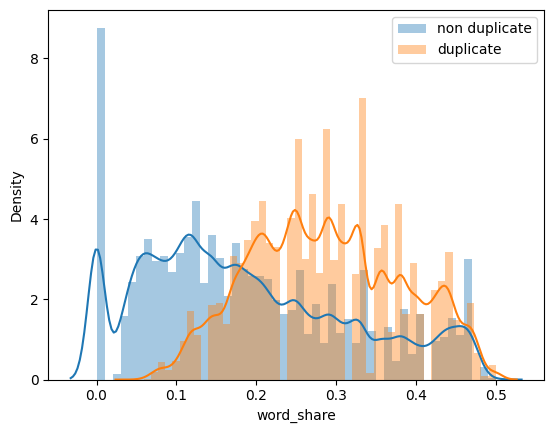

In [115]:
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

In [116]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [78]:
questions = list(ques_df['question1'].astype(str)) + list(ques_df['question2'].astype(str))

tfidf = TfidfVectorizer(max_features=3000)
tfidf.fit(questions[:50000])  

batch_size = 50000
sparse_batches = []

for i in range(0, len(questions), batch_size):
    batch = questions[i:i+batch_size]
    X_batch = tfidf.transform(batch)  
    sparse_batches.append(X_batch)

full_sparse_matrix = vstack(sparse_batches)

n = len(ques_df)
q1_sparse = full_sparse_matrix[:n]
q2_sparse = full_sparse_matrix[n:]

print(f"q1 shape: {q1_sparse.shape}, q2 shape: {q2_sparse.shape}")

q1 shape: (404287, 3000), q2 shape: (404287, 3000)


In [79]:
engineered_features = df[['word_common', 'word_share', 'q1_len', 'q2_len', 'word_total', 'q1_num_words', 'q2_num_words']].values

scaler = StandardScaler()
engineered_features = scaler.fit_transform(engineered_features)

In [80]:
from scipy.sparse import hstack, csr_matrix

engineered_sparse = csr_matrix(engineered_features)

X = hstack([q1_sparse, q2_sparse, engineered_sparse])
y = df['is_duplicate'].astype(int)

In [81]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [82]:
X_train.shape

(323429, 6007)

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

* This code trains and evaluates the following classification models:

    Logistic Regression

    Naive Bayes

    Random Forest

    AdaBoost

    XGBoost

    evaluates their performance on the test set using metrics like accuracy, precision, recall, and F1, and visualizes the results using confusion matrices.

 Model: Logistic Regression
 Accuracy:  0.7788
 Precision: 0.7168
 Recall:    0.6615
 F1 Score:  0.6880


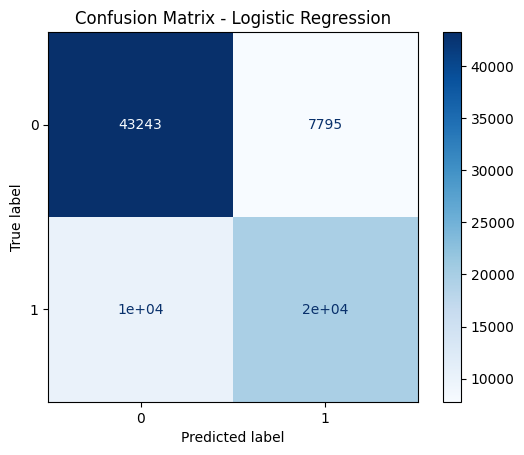

 Model: Random Forest
 Accuracy:  0.8236
 Precision: 0.7928
 Recall:    0.7062
 F1 Score:  0.7470


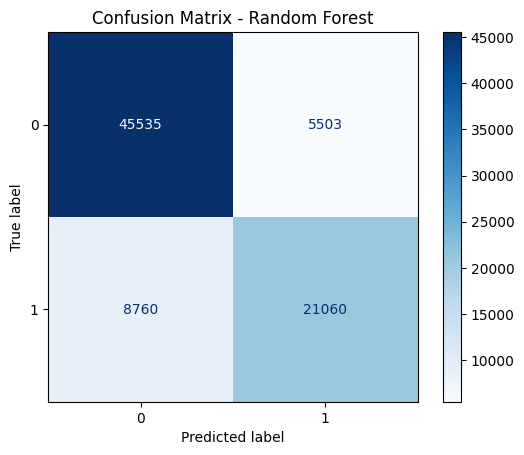

 Model: AdaBoost
 Accuracy:  0.6915
 Precision: 0.5771
 Recall:    0.6114
 F1 Score:  0.5938


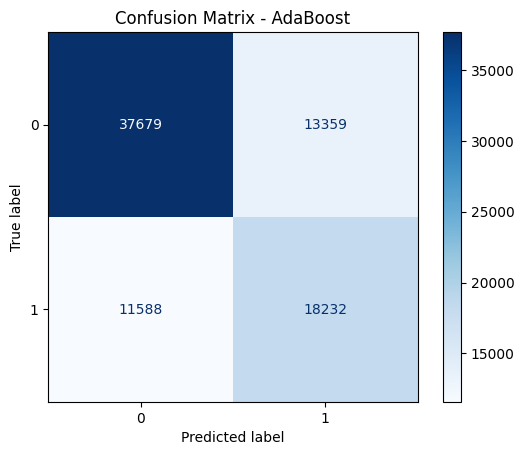

 Model: XGBoost
 Accuracy:  0.7827
 Precision: 0.7013
 Recall:    0.7158
 F1 Score:  0.7085


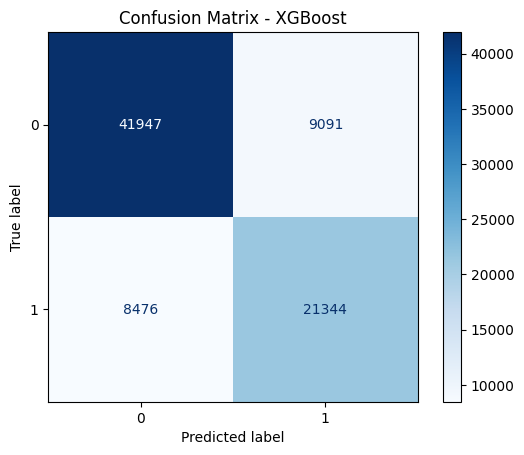

In [85]:
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

model_names = []
f1_scores = []
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    model_names.append(name)
    f1_scores.append(f1)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4)
    })

    print(f" Model: {name}")
    print(f" Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1 Score:  {f1:.4f}")
    print("="*40)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.grid(False)
    plt.show()

# Model Performance Summary Table : 
    The table below presents the evaluation metrics for each machine learning model used in the duplicate question detection task:

    * Metric Description : 
        1. Accuracy	Overall correctness of the model’s predictions (can be misleading in imbalance).
        2. Precision	Of the predicted duplicates, how many were actually correct.
        3. Recall	Of the actual duplicates, how many were correctly identified.
        4. F1 Score	Harmonic mean of Precision and Recall — best when classes are imbalanced.

In [86]:
results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.7788,0.7168,0.6615,0.6880
1,Random Forest,0.8236,0.7928,0.7062,0.7470
2,AdaBoost,0.6915,0.5771,0.6114,0.5938
3,XGBoost,0.7827,0.7013,0.7158,0.7085


# Model Comparison Based on F1 Score
The below bar chart illustrates the F1 Scores achieved by different machine learning models trained for duplicate question detection

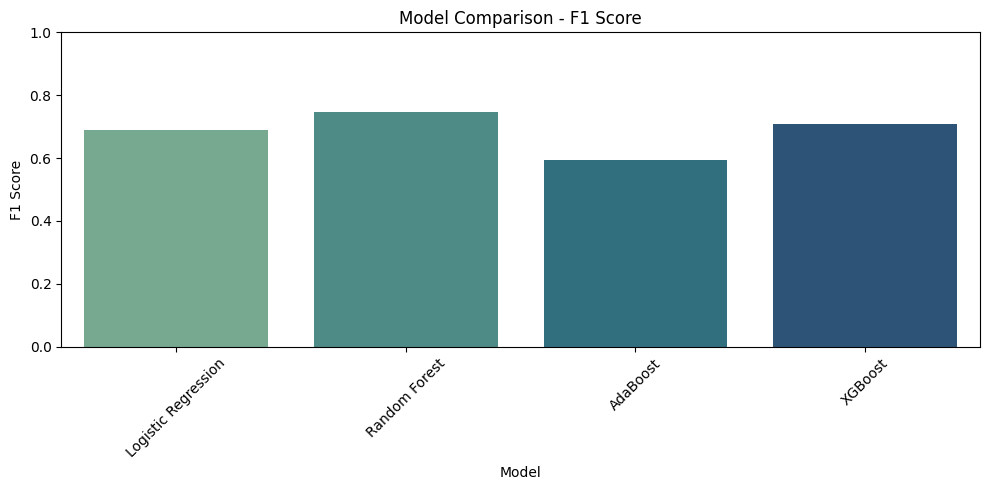

In [87]:
results_df = pd.DataFrame({'Model': model_names, 'F1 Score': f1_scores})

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='F1 Score', hue='Model', data=results_df, palette="crest", legend=False)
plt.title("Model Comparison - F1 Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()